<a href="https://colab.research.google.com/github/MoritaHiroki87/ZZ_MachineLearningNote/blob/master/%E3%83%88%E3%83%AC%E3%83%BC%E3%83%8A%E3%81%A8%E3%82%A8%E3%82%AF%E3%82%B9%E3%83%86%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16 トレーナとエクステンション
前回は訓練のループをWhile文で記述した。内容的には下記の通り。

 - イテレータがデータセットからデータを取り出し、ミニバッチを作成する
 - ミニバッチをネットワークに入力し、順伝播の計算を行う
 - ネットワークの出力と目標値を使って目的関数の値（損失）を計算する
 - 逆伝播によって各パラメータについての目的関数の勾配を計算する
 - 求まった勾配を使ってパラメータを更新する
 
 これらをまとめたのがトレーナ。
 
 そしてトレーナにはエクステンションという、可視化とかログの保存をしてくれる関数が用意されている。

## 16.1 トレーナの使用方法
### 16.1.1 トレーナの概要
一応、こういう構造らしい。


 - データセット (dataset) : 訓練や検証に使用するためのデータの集合です。
 - イテレータ (iterator) : データセットの一部をミニバッチとして切り出し、訓練中繰り返しデータセット内のデータを利用しやすくする機能を持ちます。
 - ネットワーク (network) : 訓練を行いたいネットワークです。パラメータを保持し、ミニバッチを入力として損失を計算します。
 - オプティマイザ (optimizer) : 選択された最適化の手法を用いて、ネットワークのパラメータの更新を行います。
 - アップデータ (updater) : イテレータ・オプティマイザを統括し、順伝播・損失・逆伝播の計算、そしてパラメータの更新（オプティマイザの呼び出し）という、訓練ループ内の定型的な処理を実行します。
 - トレーナ (trainer) : アップデータを受け取り、訓練全体の管理を行います。イテレータを用いてミニバッチを繰り返し作成し、オプティマイザを使ってネットワークのパラメータを更新します。訓練の終了タイミングの決定や、設定されたエクステンションの呼び出しも担います。
 - エクステンション (extension) : トレーナに設定することができる付加的な機能です。エクステンションは複数設定することができます。よく利用されるエクステンションには、訓練の途中結果の保存や、検証用データセットによる訓練途中での性能の検証、訓練進捗の可視化などがあります。



In [0]:
import numpy as np
import matplotlib as plt

import chainer
import chainer.links as L
import chainer.functions as F

### 16.1.2 データセットの準備
sklearnのirisデータを読み込んでTupleDatasetに入れるぞ。投げれとしては、

1. irisのデータセットを入力値と出力値に分割
1. TupleDatasetでくっつける
1. split_dataset_randomでランダムなデータを分割

こんな具合。

In [0]:
from sklearn.datasets import load_iris

# Irisデータセットの読み込み
dataset = load_iris()

# 入力値と目標値を別々の変数へ格納
x = dataset.data
t = dataset.target

# Chainerがデフォルトで使うfloat32に変換
x = np.array(x, np.float32)
t = np.array(t, np.int32)

In [0]:
from chainer.datasets import TupleDataset

# 入力値と目標値を引数に与え、"TupleDataset"オブジェクトを作成
# 入力値の二次元リスト、出力値のリストを与えるといい感じにリストを結合してくれる。
dataset = TupleDataset(x, t)

In [0]:
from chainer.datasets import split_dataset_random

n_train = int(len(dataset) * 0.7) # 訓練
n_valid = int(len(dataset) * 0.1) # 検証　テストは0.2

# ランダムな並びで分割してくれる。第二引数にひとつ目の変数の割合
train, valid_test = split_dataset_random(dataset, n_train, seed=0)
valid, test = split_dataset_random(valid_test, n_valid, seed=0)


print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('Test dataset size:', len(test))

Training dataset size: 105
Validation dataset size: 15
Test dataset size: 30


### 16.1.3 イテレータの準備
これイテレータってなんのためだろうな？

In [0]:
from chainer import iterators

batchsize = 32

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, shuffle=False, repeat=False)

### 16.1.4 ネットワークの準備
３層のパーセプトロン作るよ。

In [0]:
class MLP(chainer.Chain):
    
    # ここn_mid_unitsとかの変数名は適当でいいのかな？
    def __init__(self, n_mid_units=100, n_out=3):
        super().__init__()
        
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units) # ここ入力の次元数はNoneでいいのか？　→ これ自動的に設定される見たい。
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)
            
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

### 16.1.5 アップデータの準備
訓練ループを自分で書く時のステップはこちら。

1. データセットからミニバッチを作成
1. 順伝播（forward）の計算
1. 損失（loss）の計算
1. 逆伝播（backward）の計算
1. オプティマイザによってパラメータを更新

下記のように実装してきた。

```
# 1. データセットからミニバッチを作成
train_batch = train_iter.next()
x, t = concat_examples(train_batch)

# 2. 順伝播（forward）の計算
y = net(x)

# 3. 損失（loss）の計算
loss = F.softmax_cross_entropy(y, t)

# 4. 逆伝播（backward）の計算
net.cleargrads()
loss.backward()

# 5. オプティマイザによってパラメータを更新
optimizer.update()
```

ほんで、これを今回はアップデータで実装する。１をイテレータで、２〜５をオプティマイザでやる。


In [0]:
from chainer import optimizers
from chainer import training

# ネットワークを作成
predictor = MLP()

# L.Cleassifier でラップし、損失の計算などをモデルに含める
# ここ、targetは渡さなくていいのか？
net = L.Classifier(predictor)

# 最適化手法を選択してオプティマイザを作成し、最適化対象のネットワークを持たせる
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

# アップデータにイテレータとオプティマイザを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=-1)# device=-1でCPUでの計算実行を指定

### 16.1.6 トレーナの作成と終了タイミングの指定
エポックってのはデータセット全体を一周することなんだな。へー。

In [0]:
trainer = training.Trainer(updater, (30, 'epoch'), out='results/iris_result1')

### 16.1.7 エクステンション
訓練ループ中に色々処理を付け加える。
訓練中に処理が中断されてしまった時のためのバックアップをスナップショットとして持っておくとか。

In [0]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ParameterStatistics(net.predictor.fc1, {'mean': np.mean}, report_grads=True))

###16.1.9 訓練の開始

In [0]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy  fc1/W/data/mean  elapsed_time
1           4           5.49875     0.335938       1.33423        0.4                -0.0178185       0.0396678     
2           7           1.25888     0.416667       0.996337       0.333333           -0.0622161       0.647594      
3           10          0.891508    0.510417       0.674959       0.6                -0.0931543       1.20639       
4           14          0.561669    0.6875         0.66899        0.6                -0.119068        1.82706       
5           17          1.15735     0.552083       5.82647        0.4                -0.140324        2.41696       
6           20          3.05163     0.385417       1.09907        0.4                -0.175262        3.15061       
7           23          0.993136    0.395833       0.700503       0.6                -0.206401        3.74017       
8           27          1.08461     0.632812       8.27806        

In [0]:
!ls results/iris_result1/

accuracy.png	   snapshot_epoch-13  snapshot_epoch-21  snapshot_epoch-3
cg.dot		   snapshot_epoch-14  snapshot_epoch-22  snapshot_epoch-30
log		   snapshot_epoch-15  snapshot_epoch-23  snapshot_epoch-4
loss.png	   snapshot_epoch-16  snapshot_epoch-24  snapshot_epoch-5
mean.png	   snapshot_epoch-17  snapshot_epoch-25  snapshot_epoch-6
snapshot_epoch-1   snapshot_epoch-18  snapshot_epoch-26  snapshot_epoch-7
snapshot_epoch-10  snapshot_epoch-19  snapshot_epoch-27  snapshot_epoch-8
snapshot_epoch-11  snapshot_epoch-2   snapshot_epoch-28  snapshot_epoch-9
snapshot_epoch-12  snapshot_epoch-20  snapshot_epoch-29


#### 16.1.9.1 ログファイルの確認

In [0]:
import json
import pandas as pd

log = json.load(open('results/iris_result1/log'))

df_result = pd.DataFrame(log)

In [0]:
df_result.tail(10)

,elapsed_time,epoch,fc1/W/data/mean,fc1/W/grad/mean,fc1/b/data/mean,fc1/b/grad/mean,iteration,main/accuracy,main/loss,val/main/accuracy,val/main/loss
20,12.354038,21,-0.437874,-0.003648,-0.132093,-0.000755,69,0.916667,0.274637,0.800000,0.635955
21,12.974817,22,-0.439938,0.000523,-0.133330,0.000347,73,0.921875,0.212036,0.800000,0.318705
22,13.539363,23,-0.441083,0.000083,-0.134291,0.000168,76,0.947917,0.202653,0.933333,0.231656
23,14.098340,24,-0.441516,0.001562,-0.134921,0.000481,79,0.979167,0.132712,0.933333,0.202709
24,14.694751,25,-0.442035,-0.001304,-0.135570,-0.000193,83,0.984375,0.127451,0.933333,0.161624
25,15.287764,26,-0.441977,0.003476,-0.136045,0.000966,86,0.968750,0.176844,0.933333,0.305013
26,15.872668,27,-0.441717,0.001821,-0.136386,0.000683,89,0.906250,0.196027,0.933333,0.282004
27,16.465493,28,-0.441088,0.001321,-0.136800,0.000830,92,0.854167,0.268649,0.866667,0.329232
28,17.260768,29,-0.440743,-0.002792,-0.137556,-0.000513,96,0.921875,0.187011,1.000000,0.116307
29,17.864507,30,-0.440158,-0.003464,-0.138181,-0.000761,99,0.927083,0.155955,0.866667,0.233001


#### 16.1.9.2 PlotReportで作成されたグラフを見る

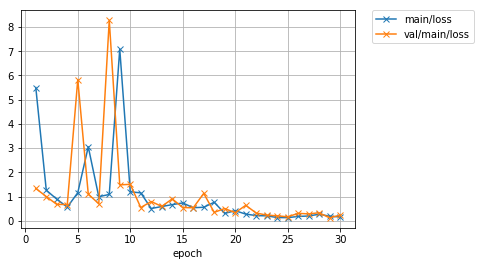

In [0]:
from IPython.display import Image
Image('results/iris_result1/loss.png')

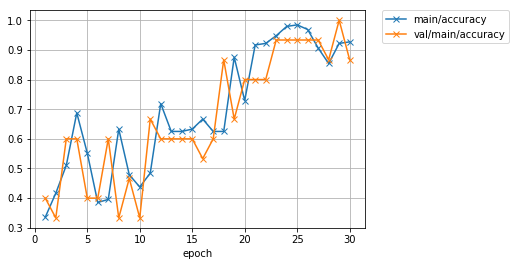

In [0]:
Image('results/iris_result1/accuracy.png')


#### 16.1.9.3 計算グラフの可視化


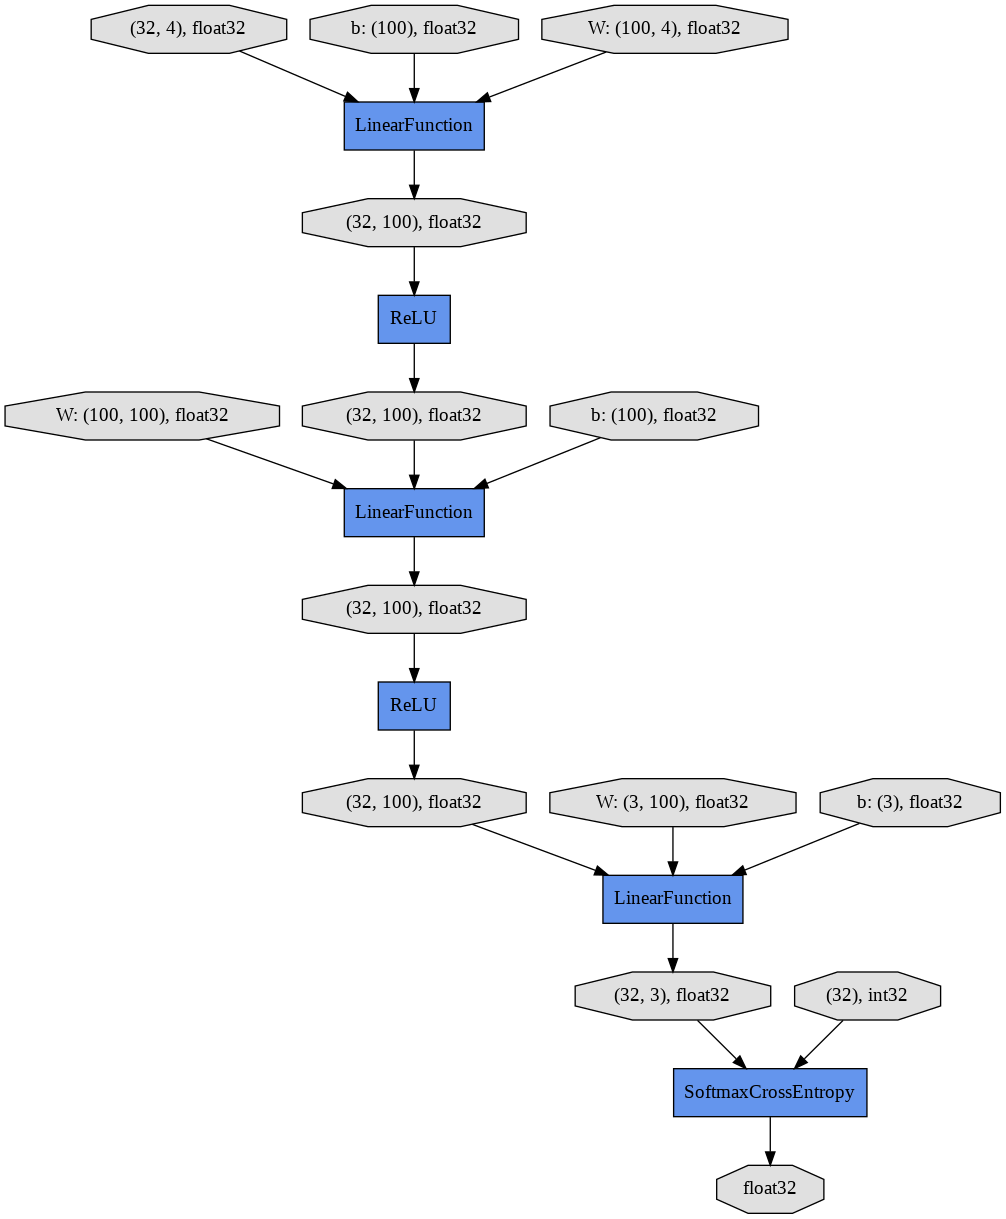

In [0]:
import pydot

file = pydot.graph_from_dot_file('results/iris_result1/cg.dot')
file[0].write_png('graph.png')
Image('graph.png', width=600, height=600)